# Task 1 – Search Engine: Robot de Entrega

**Proyecto 1 – Inteligencia Artificial**

Este notebook implementa el motor de búsqueda para un robot de entrega que:
1. **Task 1.1** – Discretiza una imagen de laberinto en una grilla de nodos
2. **Task 1.2** – Resuelve el laberinto con BFS y DFS (framework genérico OOP)
3. **Task 1.3** – Implementa A* con heurística de distancia Manhattan

## 0. Importación de Librerías

In [60]:
from __future__ import annotations

from maze_solver import *

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.dpi"] = 120


## 1. Carga y Preprocesamiento de la Imagen

Se carga la imagen del laberinto (.png o .bmp), se convierte a un arreglo RGB NumPy y se valida que sea cuadrada.

**Convención de colores:**
| Color | Significado |
|-------|-------------|
| Blanco ~(255,255,255) | Camino libre |
| Negro (0,0,0) | Pared (intransitable) |
| Rojo ~(255,0,0) | Punto de inicio |
| Verde ~(0,255,0) | Meta (puede haber varias) |

Imagen cargada: assets/turing.bmp  →  640×640 px


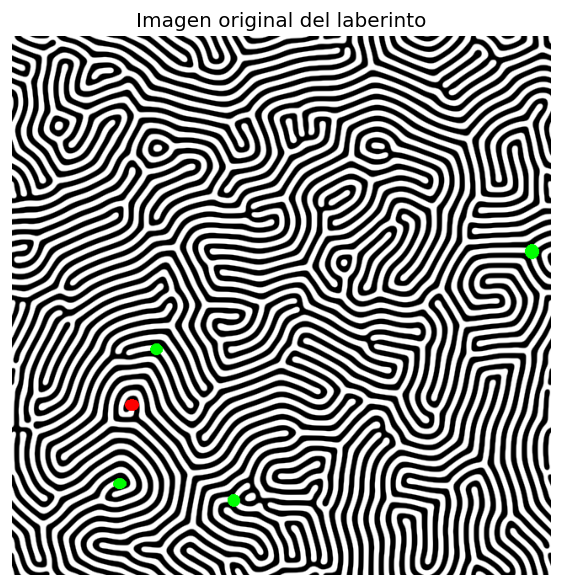

In [61]:
# ── Parámetro: ruta de la imagen ──────────────────────────────────────────────
IMAGE_PATH = os.path.join("assets", "turing.bmp")   # Cambiar según el laberinto

# ── Carpeta de salida para imágenes generadas ─────────────────────────────────
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ── Carga ─────────────────────────────────────────────────────────────────────
img = Image.open(IMAGE_PATH).convert("RGB")
img_array = np.array(img, dtype=np.uint8)

height, width, _ = img_array.shape
if height != width:
    print(f"⚠ La imagen no es cuadrada: {width}×{height} px (se usarán {height//TILE_SIZE if 'TILE_SIZE' in dir() else height} × {width//TILE_SIZE if 'TILE_SIZE' in dir() else width} tiles)")
print(f"Imagen cargada: {IMAGE_PATH}  →  {width}×{height} px")

# ── Vista previa ──────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img_array)
ax.set_title("Imagen original del laberinto")
ax.axis("off")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "01_original_image.png"), bbox_inches="tight")
plt.show()


## Task 1.1 – Discretización del Mundo

Se agrupa la imagen en *tiles* de `TILE_SIZE × TILE_SIZE` píxeles. Para cada tile se calcula el color promedio y se clasifica el nodo según umbrales de color.

### Tipos de nodo

```
FREE  = 0   (blanco)
WALL  = 1   (negro)
START = 2   (rojo)
GOAL  = 3   (verde)
```

In [62]:
# ── Ejecutar discretización ────────────────────────────────────────────────────
# TILE_SIZE=2: captura mejor las curvas finas (tile=6 promedia pared+pasillo)
TILE_SIZE = 2  # Ajustar según resolución de la imagen

grid = discretize(img_array, tile_size=TILE_SIZE)
print(f"Grilla discretizada: {grid.shape[0]} filas × {grid.shape[1]} columnas  (tile_size={TILE_SIZE})")

Grilla discretizada: 320 filas × 320 columnas  (tile_size=2)


### Task 1.1 – Identificación de Inicio, Metas y Obstáculos

In [63]:
# ── Extraer posiciones ────────────────────────────────────────────────────────
start_pos, goal_positions, n_walls = extract_key_positions(grid)

total_cells = grid.shape[0] * grid.shape[1]
print(f"Inicio     : {start_pos}")
print(f"Metas ({len(goal_positions):>2}) : {goal_positions}")
print(f"Paredes    : {n_walls}  ({100*n_walls/total_cells:.1f}% de la grilla)")
print(f"Libres     : {total_cells - n_walls - 1 - len(goal_positions)}")


  ⚠ 46 tiles START detectados → centroide en (219, 71)
Inicio     : (219, 71)
Metas (175) : [(124, 306), (124, 307), (124, 308), (124, 309), (124, 310), (125, 305), (125, 306), (125, 307), (125, 308), (125, 309), (125, 310), (125, 311), (126, 305), (126, 306), (126, 307), (126, 308), (126, 309), (126, 310), (126, 311), (126, 312), (127, 305), (127, 306), (127, 307), (127, 308), (127, 309), (127, 310), (127, 311), (127, 312), (128, 304), (128, 305), (128, 306), (128, 307), (128, 308), (128, 309), (128, 310), (128, 311), (128, 312), (129, 305), (129, 306), (129, 307), (129, 308), (129, 309), (129, 310), (129, 311), (129, 312), (130, 305), (130, 306), (130, 307), (130, 308), (130, 309), (130, 310), (130, 311), (131, 306), (131, 307), (131, 308), (131, 309), (131, 310), (183, 83), (183, 84), (183, 85), (183, 86), (183, 87), (184, 83), (184, 84), (184, 85), (184, 86), (184, 87), (184, 88), (185, 82), (185, 83), (185, 84), (185, 85), (185, 86), (185, 87), (185, 88), (185, 89), (186, 82), (18

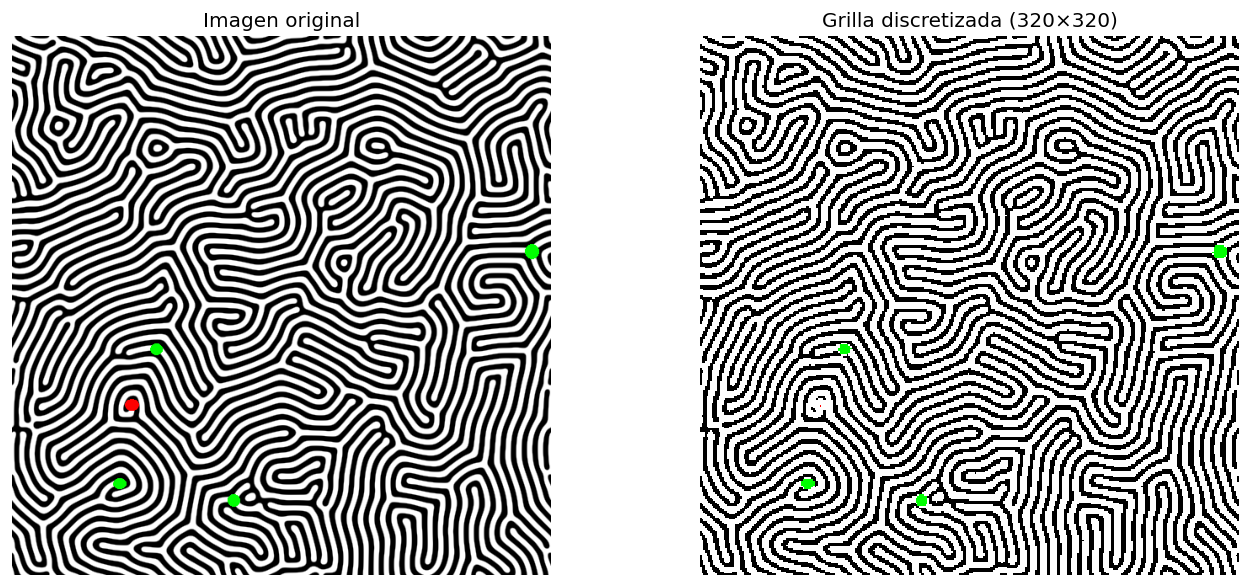

In [64]:
# ── Visualización de la grilla discretizada ───────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_array)
axes[0].set_title("Imagen original")
axes[0].axis("off")

axes[1].imshow(grid_to_rgb(grid), interpolation="nearest")
axes[1].set_title(f"Grilla discretizada ({grid.shape[0]}×{grid.shape[1]})")
axes[1].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "02_discretized_grid.png"), bbox_inches="tight")
plt.show()


## Task 1.2 – Framework Abstracto de Problemas de Búsqueda (OOP)

Se define una **clase abstracta** `SearchProblem` que modela formalmente un problema de búsqueda con:
- `initial_state()` – estado inicial
- `goal_test(state)` – prueba de meta
- `actions(state)` – acciones disponibles
- `result(state, action)` – estado sucesor
- `step_cost(state, action, next_state)` – costo del paso

Luego se implementa `MazeProblem` que recibe la grilla discretizada y deduce las funciones del framework automáticamente.

In [65]:
# ── Instanciar el problema ────────────────────────────────────────────────────
problem = MazeProblem(grid, start_pos, goal_positions)
print(f"MazeProblem creado: inicio={problem.initial_state()}, "
      f"metas={len(problem._goals)}, tamaño={problem.rows}×{problem.cols}")


MazeProblem creado: inicio=(219, 71), metas=175, tamaño=320×320


### Graph Search Genérico y clase Node

Se define la clase `Node` para representar nodos del árbol de búsqueda y se implementa la función `graph_search` genérica que recibe una frontera (cola o pila) y devuelve la ruta solución.

### Task 1.2 – BFS (Breadth-First Search)

BFS utiliza una cola FIFO como frontera. Encuentra el camino con la **menor cantidad de pasos** (costo uniforme = 1).

In [66]:
# ── Ejecutar BFS ─────────────────────────────────────────────────────────────
bfs_result = bfs(problem)
print("BFS:", bfs_result)


BFS: SearchResult(✓, pasos=610, costo=610.0, explorados=5625)


### Task 1.2 – DFS (Depth-First Search)

DFS utiliza una pila LIFO como frontera. Explora caminos rápidamente pero **no garantiza** encontrar la ruta más corta.

In [67]:
# ── Ejecutar DFS ─────────────────────────────────────────────────────────────
dfs_result = dfs(problem)
print("DFS:", dfs_result)


DFS: SearchResult(✓, pasos=1216, costo=1216.0, explorados=4831)


### Task 1.2 – Visualización: BFS vs DFS sobre imagen original

Se dibuja la ruta encontrada como línea sobre la imagen original del laberinto, mapeando coordenadas de grilla a píxeles.

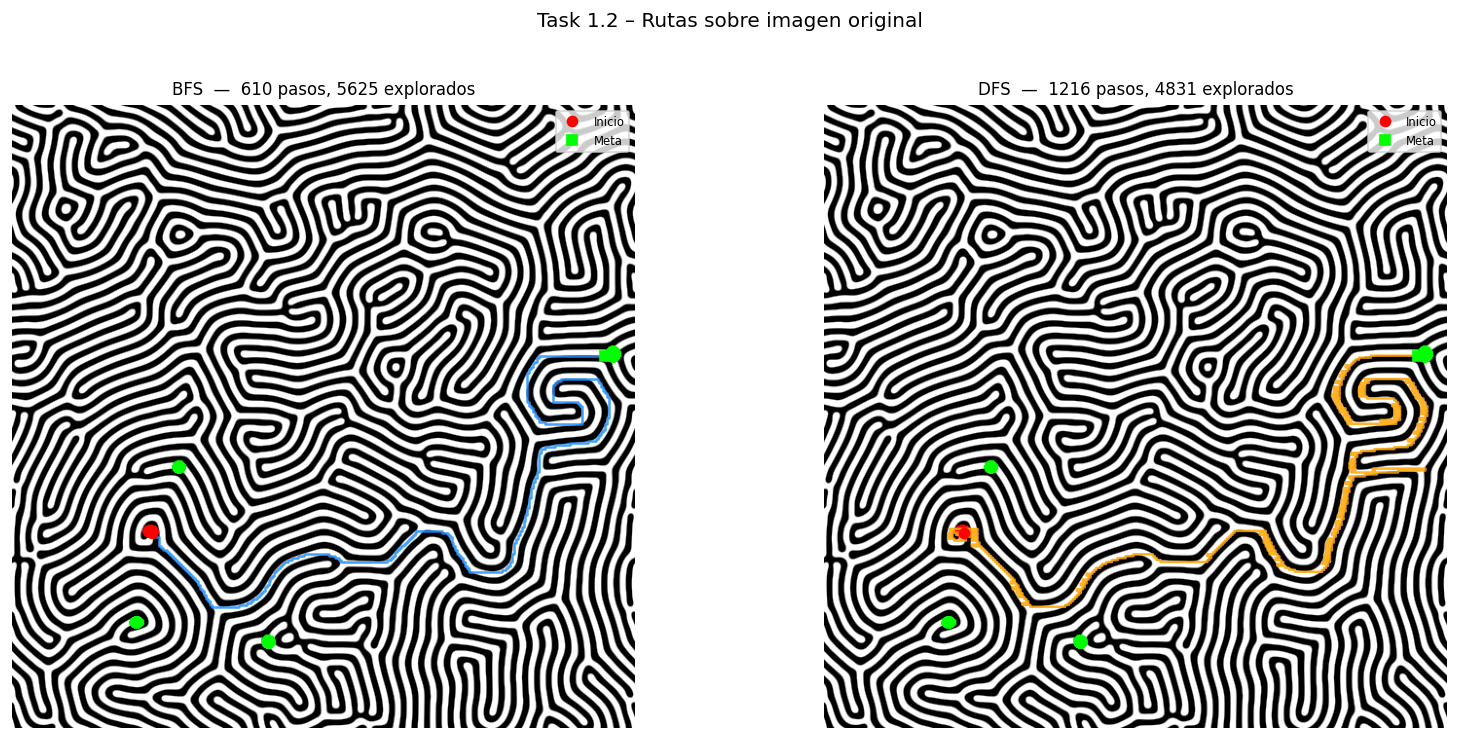

In [68]:
# ── Funciones de visualización ─────────────────────────────────────────────────

def grid_to_pixel(r: int, c: int, tile_size: int) -> Tuple[float, float]:
    """Convierte coordenada de grilla (row, col) al centro del tile en píxeles."""
    px = c * tile_size + tile_size / 2
    py = r * tile_size + tile_size / 2
    return px, py


def draw_path_on_image(
    ax,
    img_array: np.ndarray,
    path: List[State],
    tile_size: int,
    color: str = "blue",
    title: str = "",
) -> None:
    """Dibuja la ruta como una línea sobre la imagen original."""
    ax.imshow(img_array)
    if path:
        xs = [grid_to_pixel(r, c, tile_size)[0] for r, c in path]
        ys = [grid_to_pixel(r, c, tile_size)[1] for r, c in path]
        ax.plot(xs, ys, color=color, linewidth=1.5, alpha=0.85)
        # Marcar inicio y fin
        ax.plot(xs[0], ys[0], "o", color="red", markersize=6, label="Inicio")
        ax.plot(xs[-1], ys[-1], "s", color="lime", markersize=6, label="Meta")
        ax.legend(loc="upper right", fontsize=7)
    ax.set_title(title, fontsize=10)
    ax.axis("off")


# ── Comparación BFS vs DFS ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

draw_path_on_image(
    axes[0], img_array, bfs_result.path, TILE_SIZE,
    color="dodgerblue",
    title=f"BFS  —  {len(bfs_result.path)-1} pasos, {bfs_result.nodes_explored} explorados",
)
draw_path_on_image(
    axes[1], img_array, dfs_result.path, TILE_SIZE,
    color="orange",
    title=f"DFS  —  {len(dfs_result.path)-1} pasos, {dfs_result.nodes_explored} explorados",
)

plt.suptitle("Task 1.2 – Rutas sobre imagen original", fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "03_bfs_dfs_original.png"), bbox_inches="tight")
plt.show()

## Task 1.3 – Búsqueda A* (A-star)

Se implementa A* con cola de prioridad (`heapq`). La función de evaluación es:

$$f(n) = g(n) + h(n)$$

donde:
- $g(n)$ = costo acumulado desde el inicio
- $h(n)$ = **distancia Manhattan** al nodo meta más cercano (heurística admisible y consistente)

Inicialmente, el costo de moverse a cualquier celda no-pared es **1**.

In [69]:
# ── Ejecutar A* ──────────────────────────────────────────────────────────────
astar_result = astar(problem, manhattan_heuristic)
print("A*:", astar_result)


A*: SearchResult(✓, pasos=610, costo=610.0, explorados=4910)


### Task 1.3 – Visualización de A* sobre la grilla discreta

Se renderiza la ruta de A* sobre la representación discreta (no la imagen original), según lo pedido en la especificación. Se colorean las celdas por tipo y se superpone la ruta en azul.

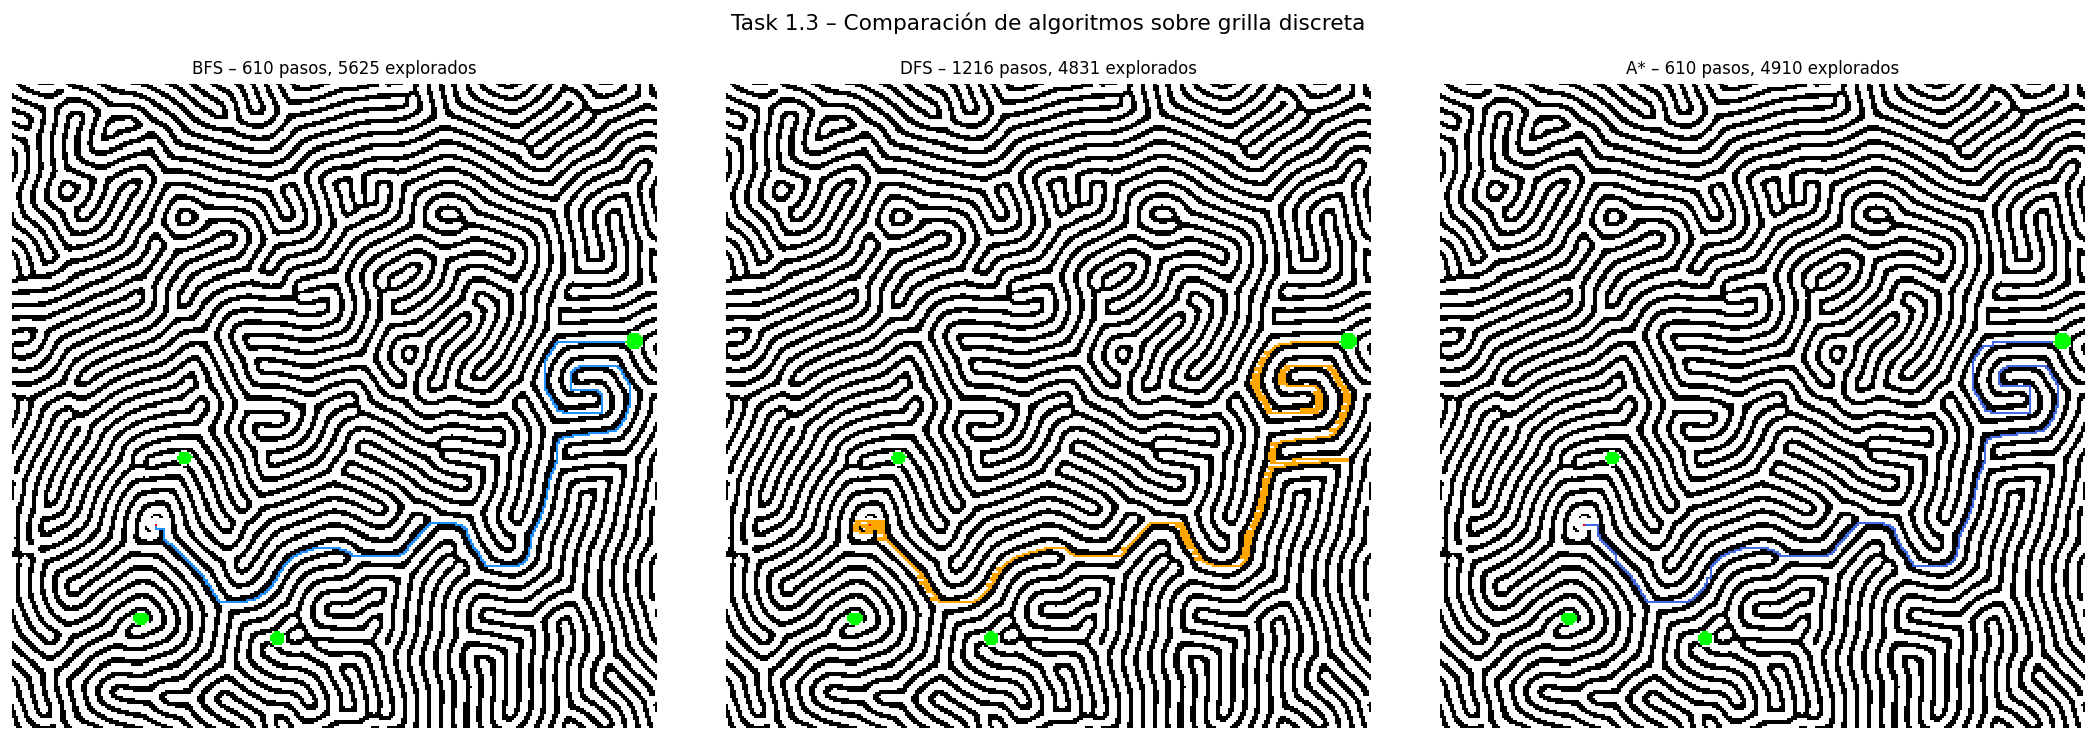

In [70]:
# ── Visualización discreta de A* ──────────────────────────────────────────────

def draw_path_on_grid(
    ax,
    grid: np.ndarray,
    path: List[State],
    title: str = "",
    path_color: List[int] | None = None,
    explored_color: List[int] | None = None,
) -> None:
    """Dibuja la ruta sobre la grilla discreta con celdas coloreadas.

    Parameters
    ----------
    ax : matplotlib Axes
    grid : np.ndarray de CellType
    path : lista de (row, col)
    title : título del gráfico
    path_color : color RGB [R, G, B] para la ruta
    explored_color : (no usado aquí, reservado para expansión futura)
    """
    if path_color is None:
        path_color = [65, 105, 225]  # Royal Blue

    rgb = grid_to_rgb(grid).copy()

    # Pintar la ruta
    for r, c in path:
        # No sobrescribir inicio ni meta para mantener claridad visual
        if grid[r, c] not in (CellType.START, CellType.GOAL):
            rgb[r, c] = path_color

    ax.imshow(rgb, interpolation="nearest")
    ax.set_title(title, fontsize=10)
    ax.axis("off")


# ── Comparación final: BFS vs DFS vs A* en grilla discreta ───────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

draw_path_on_grid(
    axes[0], grid, bfs_result.path,
    title=f"BFS – {len(bfs_result.path)-1} pasos, {bfs_result.nodes_explored} explorados",
    path_color=[30, 144, 255],
)

draw_path_on_grid(
    axes[1], grid, dfs_result.path,
    title=f"DFS – {len(dfs_result.path)-1} pasos, {dfs_result.nodes_explored} explorados",
    path_color=[255, 165, 0],
)

draw_path_on_grid(
    axes[2], grid, astar_result.path,
    title=f"A* – {len(astar_result.path)-1} pasos, {astar_result.nodes_explored} explorados",
    path_color=[65, 105, 225],
)

plt.suptitle("Task 1.3 – Comparación de algoritmos sobre grilla discreta", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "04_algorithms_grid.png"), bbox_inches="tight")
plt.show()

### Resumen comparativo

In [71]:
# ── Tabla comparativa ─────────────────────────────────────────────────────────

print(f"{'Algoritmo':<12} {'Pasos':>8} {'Costo':>8} {'Explorados':>12} {'Éxito':>7}")
print("-" * 52)
for name, res in [("BFS", bfs_result), ("DFS", dfs_result), ("A*", astar_result)]:
    steps = len(res.path) - 1 if res.success else "N/A"
    cost = f"{res.path_cost:.1f}" if res.success else "N/A"
    ok = "✓" if res.success else "✗"
    print(f"{name:<12} {str(steps):>8} {cost:>8} {res.nodes_explored:>12} {ok:>7}")

Algoritmo       Pasos    Costo   Explorados   Éxito
----------------------------------------------------
BFS               610    610.0         5625       ✓
DFS              1216   1216.0         4831       ✓
A*                610    610.0         4910       ✓
